In [1]:
# Import packages
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Blitz Prediction: Milestone 2

*Thomas Garity, Christopher Doyle, Chris Ruano, Hans Elasri, Rishi Hazra*

In **Milestone 2,** we conducted exploratory data analysis (EDA). This included:
- Loading all data tables and inspecting the variables
  - As you will read below, our data is stored in separate tables for games, players, plays, player_plays (what each player does on each play), and then finally the X/Y coordinates of the player on each play.
- Preprocessing
  - We have infilled nAns where needed and one-hot encoded player positions and team names -- we thought about dropping these variables but they may prove useful later for modelling.
- Creating an indicator response variable: `isBlitz`
  - This is waht we seek to predict, using mainly data from the plays and player_play datasets. The response variable was used using data from the player_play dataset, and then we filtered based on the conditions of that play (whether the ball was passed or rushed, etc.)
- Creating a df to use for preliminary modelling: `blitz_df`

We also report on some weaknesses / things yet to explore further, at the bottom of our notebook.


### Data Structure

Our data can be downloaded from the 2025 Big Data Bowl on  <a href="https://www.kaggle.com/competitions/nfl-big-data-bowl-2025/data">Kaggle</a>

or using the Kaggle API: 

`kaggle competitions download -c nfl-big-data-bowl-2025`


**Instructions:**
- Download the dataset and unzip the file `nfl-big-data-bowl-2025.zip`
- The datasets will now saved in a `\nfl-big-data-bowl-2205` directory within the project repo
- Ensure that this directory is listed out in your `.gitignore` file to avoid pushing/pulling this to github

Now, check that the data have been downloaded:

In [2]:
# Ensure that all tables have been downloaded
print("Data Availabe: ")
os.listdir('./nfl-big-data-bowl-2025/')

Data Availabe: 


['plays.csv',
 'tracking_week_4.csv',
 'tracking_week_3.csv',
 'tracking_week_2.csv',
 'tracking_week_1.csv',
 'players.csv',
 'games.csv',
 'tracking_week_8.csv',
 'player_play.csv']

In [43]:
# Print the total size of the dataset
!du -sh /Users/thomasgarity/Documents/CS109B/blitzprediction/nfl-big-data-bowl-2025


3.6G	/Users/thomasgarity/Documents/CS109B/blitzprediction/nfl-big-data-bowl-2025


We see that we have 3.6GB of data downloaded. Let's now load and inspect our data:

In [3]:
# Load CSVs of data -- we only load one week of tracking to inspect its contents

plays_df = pd.read_csv('./nfl-big-data-bowl-2025/plays.csv')
players_df = pd.read_csv('./nfl-big-data-bowl-2025/players.csv')
games_df = pd.read_csv('./nfl-big-data-bowl-2025/games.csv')
player_play_df = pd.read_csv('./nfl-big-data-bowl-2025/player_play.csv')
tracking_week1 = pd.read_csv('./nfl-big-data-bowl-2025/tracking_week_1.csv')

In [4]:
# Look at first few rows
plays_df.head()

,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,defensiveTeam,yardlineSide,yardlineNumber,...,yardsGained,homeTeamWinProbabilityAdded,visitorTeamWinProbilityAdded,expectedPointsAdded,isDropback,pff_runConceptPrimary,pff_runConceptSecondary,pff_runPassOption,pff_passCoverage,pff_manZone
0,2022102302,2655,(1:54) (Shotgun) J.Burrow pass short middle to...,3,1,10,CIN,ATL,CIN,21,...,9,0.004634,-0.004634,0.702717,True,NaN,NaN,0,Cover-3,Zone
1,2022091809,3698,(2:13) (Shotgun) J.Burrow pass short right to ...,4,1,10,CIN,DAL,CIN,8,...,4,0.002847,-0.002847,-0.240509,True,NaN,NaN,0,Quarters,Zone
2,2022103004,3146,(2:00) (Shotgun) D.Mills pass short right to D...,4,3,12,HOU,TEN,HOU,20,...,6,0.000205,-0.000205,-0.218480,True,NaN,NaN,0,Quarters,Zone
3,2022110610,348,(9:28) (Shotgun) P.Mahomes pass short left to ...,1,2,10,KC,TEN,TEN,23,...,4,-0.001308,0.001308,-0.427749,True,NaN,NaN,0,Quarters,Zone
4,2022102700,2799,(2:16) (Shotgun) L.Jackson up the middle to TB...,3,2,8,BAL,TB,TB,27,...,-1,0.027141,-0.027141,-0.638912,False,MAN,READ OPTION,0,Cover-1,Man


In [5]:
players_df.head()

,nflId,height,weight,birthDate,collegeName,position,displayName
0,25511,6-4,225,1977-08-03,Michigan,QB,Tom Brady
1,29550,6-4,328,1982-01-22,Arkansas,T,Jason Peters
2,29851,6-2,225,1983-12-02,California,QB,Aaron Rodgers
3,30842,6-6,267,1984-05-19,UCLA,TE,Marcedes Lewis
4,33084,6-4,217,1985-05-17,Boston College,QB,Matt Ryan


In [6]:
games_df.head()

,gameId,season,week,gameDate,gameTimeEastern,homeTeamAbbr,visitorTeamAbbr,homeFinalScore,visitorFinalScore
0,2022090800,2022,1,9/8/2022,20:20:00,LA,BUF,10,31
1,2022091100,2022,1,9/11/2022,13:00:00,ATL,NO,26,27
2,2022091101,2022,1,9/11/2022,13:00:00,CAR,CLE,24,26
3,2022091102,2022,1,9/11/2022,13:00:00,CHI,SF,19,10
4,2022091103,2022,1,9/11/2022,13:00:00,CIN,PIT,20,23


In [7]:
player_play_df.head()

,gameId,playId,nflId,teamAbbr,hadRushAttempt,rushingYards,hadDropback,passingYards,sackYardsAsOffense,hadPassReception,...,wasRunningRoute,routeRan,blockedPlayerNFLId1,blockedPlayerNFLId2,blockedPlayerNFLId3,pressureAllowedAsBlocker,timeToPressureAllowedAsBlocker,pff_defensiveCoverageAssignment,pff_primaryDefensiveCoverageMatchupNflId,pff_secondaryDefensiveCoverageMatchupNflId
0,2022090800,56,35472,BUF,0,0,0,0,0,0,...,NaN,NaN,47917.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN
1,2022090800,56,42392,BUF,0,0,0,0,0,0,...,NaN,NaN,47917.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN
2,2022090800,56,42489,BUF,0,0,0,0,0,1,...,1.0,IN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022090800,56,44875,BUF,0,0,0,0,0,0,...,NaN,NaN,43335.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN
4,2022090800,56,44985,BUF,0,0,0,0,0,0,...,1.0,OUT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
tracking_week1.head()

,gameId,playId,nflId,displayName,frameId,frameType,time,jerseyNumber,club,playDirection,x,y,s,a,dis,o,dir,event
0,2022091200,64,35459.0,Kareem Jackson,1,BEFORE_SNAP,2022-09-13 00:16:03.5,22.0,DEN,right,51.06,28.55,0.72,0.37,0.07,246.17,68.34,huddle_break_offense
1,2022091200,64,35459.0,Kareem Jackson,2,BEFORE_SNAP,2022-09-13 00:16:03.6,22.0,DEN,right,51.13,28.57,0.71,0.36,0.07,245.41,71.21,NaN
2,2022091200,64,35459.0,Kareem Jackson,3,BEFORE_SNAP,2022-09-13 00:16:03.7,22.0,DEN,right,51.20,28.59,0.69,0.23,0.07,244.45,69.90,NaN
3,2022091200,64,35459.0,Kareem Jackson,4,BEFORE_SNAP,2022-09-13 00:16:03.8,22.0,DEN,right,51.26,28.62,0.67,0.22,0.07,244.45,67.98,NaN
4,2022091200,64,35459.0,Kareem Jackson,5,BEFORE_SNAP,2022-09-13 00:16:03.9,22.0,DEN,right,51.32,28.65,0.65,0.34,0.07,245.74,62.83,NaN


### Defining the Blitz Indicator (`isBlitz`)

In order to estimate the likelihood of a blitz based on pre-snap information, we must first clearly define what constitutes a blitz.  

Since the dataset does not include an explicit "blitz" label, we construct a proxy indicator variable, `isBlitz`, using post-play player-level statistics. This label flags a defender as blitzing if they show any of the following characteristics:

- Identified as an **initial pass rusher**  
- **Caused pressure** on the quarterback  
- **Recorded a QB hit**  
- **Credited with a sack**

These conditions collectively approximate the presence of a blitz, particularly when applied to non-defensive-line players (e.g., linebackers or defensive backs). The resulting indicator variable will serve as the target label for our blitz prediction model.


In [9]:
# Copy player_play_df
blitz_df = player_play_df.copy()

# Define blitz indicator
blitz_df['isBlitz'] = (
    (blitz_df['wasInitialPassRusher'] == 1) |
    (blitz_df['causedPressure'] == True) |
    (blitz_df['quarterbackHit'] == True) |
    (blitz_df['sackYardsAsDefense'].fillna(0) > 0)
).astype(int)

# Merge position info into blitz_df
blitz_df = blitz_df.merge(players_df[['nflId', 'position']], on='nflId', how='left')

# Sample blitzers
blitz_df[blitz_df['isBlitz'] == 1][['gameId', 'playId', 'nflId', 'position']].head()

,gameId,playId,nflId,position
12,2022090800,56,41239,DT
15,2022090800,56,43298,DE
16,2022090800,56,43335,DT
18,2022090800,56,47917,NT
34,2022090800,80,41239,DT


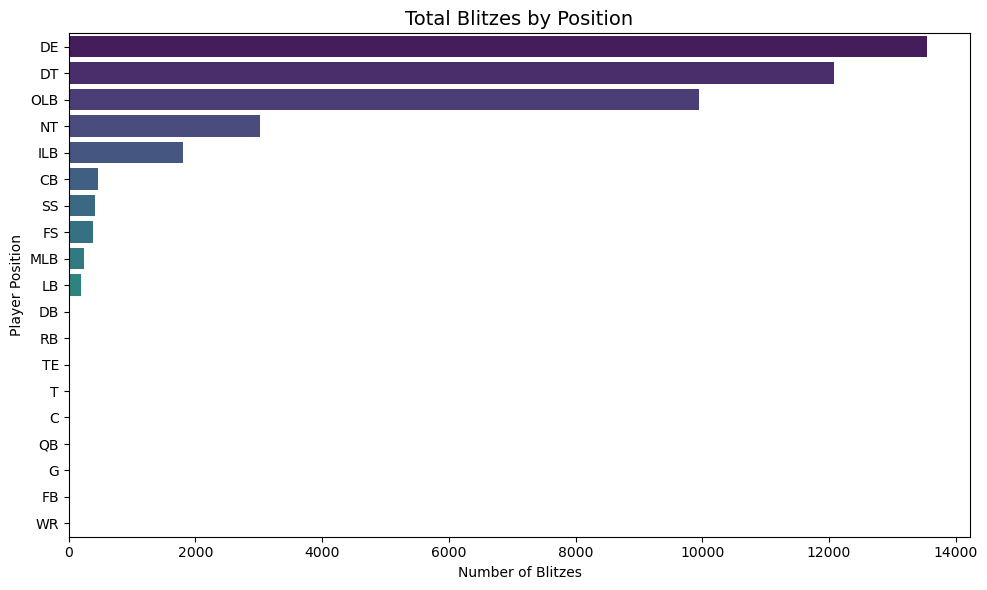

In [10]:
# Group by position to see who blitzes most
blitz_by_position = (
    blitz_df.groupby('position')['isBlitz']
    .sum()
    .reset_index()
    .sort_values(by='isBlitz', ascending=False)
)

# Plot blitz count by position
plt.figure(figsize=(10, 6))
sns.barplot(data=blitz_by_position, x='isBlitz', y='position', palette='viridis', hue='position', legend=False)

plt.title('Total Blitzes by Position', fontsize=14)
plt.xlabel('Number of Blitzes')
plt.ylabel('Player Position')
plt.tight_layout()
plt.show()

Here we see that it is **defensive** positions who blitz most, suggesting that we have correctly flagged blitzes.

### Preprocessing

Next, we preprocess our `blitz_df` to only include passing plays (blitzes on passing plays are far rarer, and teams generally need help determining when a defense will blitz on a passing play). 

#### 1. Filtering, Filling Missing Values

In [11]:
# Merge plays into blitz_df
blitz_df = blitz_df.merge(
    plays_df[['gameId', 'playId', 'isDropback', 'qbSpike', 'qbKneel', 'playAction']],
    on=['gameId', 'playId'], how='left'
)

In [12]:
playId = 56
print(f"Number of rows in playId = {playId}: {len(blitz_df[blitz_df['playId'] == playId])}")
print("Unique Values for qbSpike: ", blitz_df[blitz_df['playId'] == playId]['qbSpike'].unique())

Number of rows in playId = 56: 1012
Unique Values for qbSpike:  [False nan]


We see that there are some NANs present in the columns that we wish to use to filter ; we impute these by assuming that if `qbSpike` is true for some players on the play, then it is true for the ENTIRE play. We apply this logic to all columns that will be used to filter.



In [ ]:
for col_name in ['isDropback', 'qbSpike', 'qbKneel', 'playAction']:
  blitz_df[col_name] = blitz_df.groupby('playId')[col_name].transform(lambda x: x.ffill().bfill)

  # Check for remaining NaNs after fill
  # Count the number of rows with at least one NaN value
  nan_count = blitz_df[col_name].isna().sum()
  print(f'Number of rows in {col_name} with NaNs: {nan_count}')

Number of rows in isDropback with NaNs: 0


/var/folders/0q/yhmj_0x575vb_7r2qv4fkhs40000gn/T/ipykernel_64297/2041826653.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  blitz_df[col_name] = blitz_df.groupby('playId')[col_name].transform(lambda x: x.ffill().bfill)


Number of rows in qbSpike with NaNs: 0
Number of rows in qbKneel with NaNs: 0
Number of rows in playAction with NaNs: 0


We can see that there are still some missing values -- luckily, this will be addressed by our filtering below:

In [14]:
# Check that there is no overlap in playId between the included and excluded plays
# First, get disqualified playIds (any row matching exclusion criteria)
included_play_ids = blitz_df[
    (blitz_df['isDropback'] == True) &
    (blitz_df['qbSpike'] != True) &
    pd.notna(blitz_df['qbSpike']) &
    (blitz_df['qbKneel'] != True) &
    (blitz_df['playAction'] != True)
]['playId'].unique()

# Then include only playIds NOT in excluded list
excluded_play_df = blitz_df[~blitz_df['playId'].isin(included_play_ids)]

# Confirm unique playId counts
print("Total unique plays: ", blitz_df['playId'].nunique())
print("Plays included: ", len(included_play_ids))
print("Plays excluded: ", excluded_play_df['playId'].nunique())

# Check how we've reduced rows in dataset
print("Rows in original dataset: ", len(blitz_df))
filtered_blitz_df = blitz_df[blitz_df['playId'].isin(included_play_ids)]
print("Rows in filtered dataset: ", len(filtered_blitz_df))



Total unique plays:  4207
Plays included:  3473
Plays excluded:  734
Rows in original dataset:  354727
Rows in filtered dataset:  316777


So we see that we have retained most of the data, leaving us with healthy number of rows.

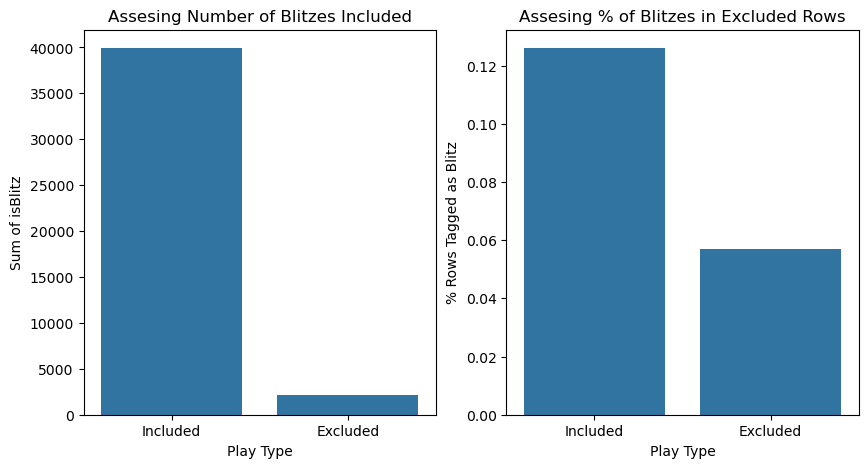

In [15]:
data = {"Play Type": ['Included',
                      'Excluded'],
        "Sum of isBlitz": [filtered_blitz_df['isBlitz'].sum(),
                           excluded_play_df['isBlitz'].sum()],
        "% Rows Tagged as Blitz": [filtered_blitz_df['isBlitz'].sum() / len(filtered_blitz_df),
                                   excluded_play_df['isBlitz'].sum()/ len(excluded_play_df)]}
data = pd.DataFrame(data)


fig, axs = plt.subplots(1, 2, figsize=(10,5))

sns.barplot(data=data, x="Play Type", y="Sum of isBlitz", ax=axs[0])
axs[0].set_title("Assesing Number of Blitzes Included")

sns.barplot(data=data, x="Play Type", y="% Rows Tagged as Blitz", ax=axs[1])
axs[1].set_title("Assesing % of Blitzes in Excluded Rows")

plt.tight_layout
plt.show()

In [16]:
# Finally, set our df to the filtered one
blitz_df = filtered_blitz_df

Here, we can deduce that our filtering has given us the desired effects:
1. We keep most of the blitzes
2. There is a markedly lower rate of blitzes (12% vs 6%) in the included vs excluded datasets.

#### 2. One Hot Encoding

Let's first check for categorical variables:

In [23]:
def print_non_numeric(df):
  # Select non-numeric columns
  non_numeric_df = df.select_dtypes(exclude=['number', 'bool'])

  # Get column names of non-numeric columns
  non_numeric_columns = non_numeric_df.columns.tolist()

  print(non_numeric_columns)

print_non_numeric(blitz_df)

['teamAbbr', 'penaltyNames', 'inMotionAtBallSnap', 'shiftSinceLineset', 'motionSinceLineset', 'routeRan', 'pff_defensiveCoverageAssignment', 'position', 'qbSpike']


In [ ]:
# Let's start by one-hot encoding the position variable
blitz_df_encoded = pd.get_dummies(blitz_df, columns=['position','routeRan', 'teamAbbr', 'penaltyNames', 'pff_defensiveCoverageAssignment', ])

# Now print our non-numeric variables
print_non_numeric(blitz_df_encoded)

['inMotionAtBallSnap', 'shiftSinceLineset', 'motionSinceLineset', 'qbSpike']
Empty DataFrame
Columns: [gameId, playId, nflId, hadRushAttempt, rushingYards, hadDropback, passingYards, sackYardsAsOffense, hadPassReception, receivingYards, wasTargettedReceiver, yardageGainedAfterTheCatch, fumbles, fumbleLost, fumbleOutOfBounds, assistedTackle, forcedFumbleAsDefense, halfSackYardsAsDefense, passDefensed, quarterbackHit, sackYardsAsDefense, safetyAsDefense, soloTackle, tackleAssist, tackleForALoss, tackleForALossYardage, hadInterception, interceptionYards, fumbleRecoveries, fumbleRecoveryYards, penaltyYards, wasInitialPassRusher, causedPressure, timeToPressureAsPassRusher, getOffTimeAsPassRusher, inMotionAtBallSnap, shiftSinceLineset, motionSinceLineset, wasRunningRoute, blockedPlayerNFLId1, blockedPlayerNFLId2, blockedPlayerNFLId3, pressureAllowedAsBlocker, timeToPressureAllowedAsBlocker, pff_primaryDefensiveCoverageMatchupNflId, pff_secondaryDefensiveCoverageMatchupNflId, isBlitz, isDropb

All that is left now is to infill NaNs in the 3 columns `['inMotionAtBallSnap', 'shiftSinceLineset', 'motionSinceLineset']`. We do this by assuming that each player keeps the same values of these 3 variables for the entire play. THIS CELL TAKES A LONG TIME TO RUN.

In [ ]:
for col_name in ['inMotionAtBallSnap', 'shiftSinceLineset', 'motionSinceLineset']:
  blitz_df_encoded[col_name] = blitz_df_encoded.groupby(['playId','nflId'])[col_name].transform(lambda x: x.ffill())


blitz_df = blitz_df_encoded

Thus we have fixed our missing values and one-hot encoded any categorical variables. We are ready to begin modelling! Some steps that may still need to be addressed are:

- Incorporating positional data -- the X and Y position of players on the field. If we wish to use those, we should begin work with the `tracking_week_x.csv` data, where x is a gameweek. This opens the door to more advanced architectures (that take in an "image" of the field and guess the next positions)
- Packaging the data into model-specific formats. Each modelling approach will require a different format of data. For example, we could try creating a "cube" where each position is saved as a "pixel" in an image of the field, and the num_channels is the number of collumns we have (excluding the position).
- Better infilling methods -- we may find that in some cases, the indicator variables above may change during a play.